In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Librerias

In [52]:
# Importamos las librerías necesarias para este análisis.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


 Cargar los resultados generados en el Notebook 02

In [53]:
# Rutas base (ajusta si las cambiaste)
BASE = "/content/drive/MyDrive/Proyecto_Grupo4"
RESULTS = f"{BASE}/Results"
os.makedirs(RESULTS, exist_ok=True)

# Archivos esperados del Notebook 02
CSV_GRID = f"{RESULTS}/02_performance_comparison.csv"          # ranking validación
CSV_ALL  = f"{RESULTS}/02_performance_comparaciones.csv"       # acumulado
CSV_TOP3 = f"{RESULTS}/02_performance_top3_test.csv"           # top3 en test
CSV_PREDS = f"{RESULTS}/02_test_predictions.csv"               # opcional (predicciones del mejor)

Cargar datos y valida que existan

In [54]:
def must_exist(path):
    assert os.path.exists(path), f"No encuentro: {path}"
    return path

df_grid = pd.read_csv(must_exist(CSV_GRID))
display(df_grid.head())

df_all = pd.read_csv(must_exist(CSV_ALL))
display(df_all.tail())

df_top3 = pd.read_csv(must_exist(CSV_TOP3))
display(df_top3)


,model,arch,activation,lr,epochs,batch_size,wd,train_time_s,val_acc,val_f1
0,nn,"[256, 128]",tanh,0.03,20,256,0.0001,74.3,0.593000,0.592976
1,softmax,linear,softmax,0.20,8,512,0.0001,4.3,0.577667,0.578823
2,softmax,linear,softmax,0.30,8,512,0.0001,5.7,0.576333,0.575327
3,nn,"[512, 256, 128]",relu,0.02,20,256,0.0001,304.1,0.514333,0.505003
4,softmax,linear,softmax,0.10,8,512,0.0001,10.4,0.486667,0.476704


,model,arch,activation,lr,epochs,batch_size,wd,train_time_s,val_acc,val_f1
1,softmax,linear,softmax,0.20,8,512,0.0001,4.3,0.577667,0.578823
2,softmax,linear,softmax,0.30,8,512,0.0001,5.7,0.576333,0.575327
3,nn,"[512, 256, 128]",relu,0.02,20,256,0.0001,304.1,0.514333,0.505003
4,softmax,linear,softmax,0.10,8,512,0.0001,10.4,0.486667,0.476704
5,nn,"[256, 128]",relu,0.02,20,256,0.0001,156.2,0.488333,0.474506


,model,arch,activation,lr,epochs,batch_size,wd,test_acc,test_f1,train_time_s_full
0,nn,"[256, 128]",tanh,0.03,20,256,0.0001,0.649333,0.648549,242.1
1,softmax,linear,softmax,0.20,8,512,0.0001,0.608000,0.606060,13.3
2,softmax,linear,softmax,0.30,8,512,0.0001,0.603333,0.601386,13.2


 Ranking final por validación

In [55]:
# Orden por val_f1 (desc) y mostrar top-10
rank_val = df_grid.sort_values(["val_f1","val_acc"], ascending=False).head(10).reset_index(drop=True)
print("Top-10 por validación (val_f1):")
display(rank_val[["model","arch","activation","lr","epochs","batch_size","wd","val_acc","val_f1","train_time_s"]])

# Guardar resumen
rank_val.to_csv(f"{RESULTS}/03_rank_val_top10.csv", index=False)
print("Guardado 03_rank_val_top10.csv")


Top-10 por validación (val_f1):


,model,arch,activation,lr,epochs,batch_size,wd,val_acc,val_f1,train_time_s
0,nn,"[256, 128]",tanh,0.03,20,256,0.0001,0.593000,0.592976,74.3
1,softmax,linear,softmax,0.20,8,512,0.0001,0.577667,0.578823,4.3
2,softmax,linear,softmax,0.30,8,512,0.0001,0.576333,0.575327,5.7
3,nn,"[512, 256, 128]",relu,0.02,20,256,0.0001,0.514333,0.505003,304.1
4,softmax,linear,softmax,0.10,8,512,0.0001,0.486667,0.476704,10.4
5,nn,"[256, 128]",relu,0.02,20,256,0.0001,0.488333,0.474506,156.2


Guardado 03_rank_val_top10.csv


Comparación Softmax vs MLP (validación)

Promedios por tipo de modelo (validación):


,model,val_acc,val_f1,train_time_s
0,nn,0.531889,0.524162,178.2
1,softmax,0.546889,0.543618,6.8


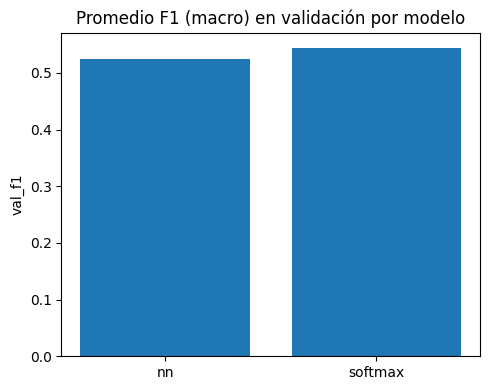

03_val_f1_promedio_por_modelo.png guardado


In [56]:
# Promedios por tipo de modelo
avg_by_model = df_grid.groupby("model")[["val_acc","val_f1","train_time_s"]].mean().reset_index()
print("Promedios por tipo de modelo (validación):")
display(avg_by_model)

# Gráfico de barras (val_f1)
plt.figure(figsize=(5,4))
plt.bar(avg_by_model["model"], avg_by_model["val_f1"])
plt.title("Promedio F1 (macro) en validación por modelo")
plt.ylabel("val_f1")
plt.tight_layout()
plt.savefig(f"{RESULTS}/03_val_f1_promedio_por_modelo.png", dpi=300)
plt.show()
print("03_val_f1_promedio_por_modelo.png guardado")


Análisis de arquitecturas (MLP)

Máximo val_f1 por arquitectura x activación (NN):


activation,relu,tanh
arch_str,,
"[256, 128]",0.474506,0.592976
"[512, 256, 128]",0.505003,NaN


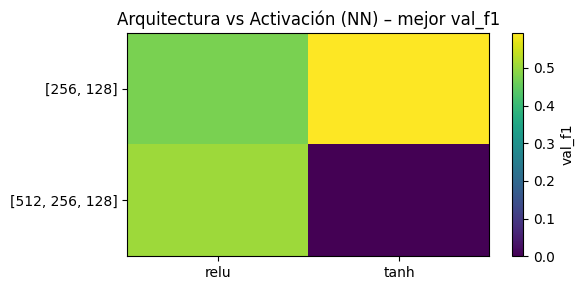

03_architecture_analysis.png guardado


In [57]:
# Filtrar solo NN y comparar capas/activación
df_nn = df_grid[df_grid["model"]=="nn"].copy()
if not df_nn.empty:
    # Normalizamos representación de 'arch' a texto legible
    df_nn["arch_str"] = df_nn["arch"].astype(str)

    # Pivot para ver mejor activación vs arquitectura (val_f1)
    pivot = df_nn.pivot_table(index="arch_str", columns="activation", values="val_f1", aggfunc="max")
    print("Máximo val_f1 por arquitectura x activación (NN):")
    display(pivot)

    # Gráfico heatmap simple con imshow
    plt.figure(figsize=(6, max(3, 0.5*len(pivot.index))))
    plt.imshow(pivot.fillna(0).values, aspect="auto")
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xticks(range(len(pivot.columns)), pivot.columns)
    plt.colorbar(label="val_f1")
    plt.title("Arquitectura vs Activación (NN) – mejor val_f1")
    plt.tight_layout()
    plt.savefig(f"{RESULTS}/03_architecture_analysis.png", dpi=300)
    plt.show()
    print("03_architecture_analysis.png guardado")
else:
    print("No hay filas de 'nn' para análisis de arquitecturas.")


Resultados finales en TEST (Top-3)

Top-3 reentrenado y evaluado en TEST:


,model,arch,activation,lr,epochs,batch_size,wd,test_acc,test_f1,train_time_s_full
0,nn,"[256, 128]",tanh,0.03,20,256,0.0001,0.649333,0.648549,242.1
1,softmax,linear,softmax,0.20,8,512,0.0001,0.608000,0.606060,13.3
2,softmax,linear,softmax,0.30,8,512,0.0001,0.603333,0.601386,13.2


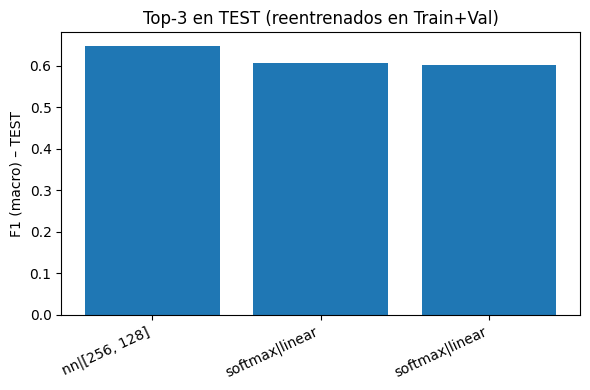

 03_top3_test_f1.png guardado


In [58]:
print("Top-3 reentrenado y evaluado en TEST:")
display(df_top3)

# Gráfico barras F1 TEST
plt.figure(figsize=(6,4))
labels = [f"{r['model']}|{r['arch']}" for _,r in df_top3.iterrows()]
plt.bar(range(len(df_top3)), df_top3["test_f1"])
plt.xticks(range(len(df_top3)), labels, rotation=25, ha='right')
plt.ylabel("F1 (macro) – TEST")
plt.title("Top-3 en TEST (reentrenados en Train+Val)")
plt.tight_layout()
plt.savefig(f"{RESULTS}/03_top3_test_f1.png", dpi=300)
plt.show()
print(" 03_top3_test_f1.png guardado")


Cargar y mostrar matriz de confusión del mejor

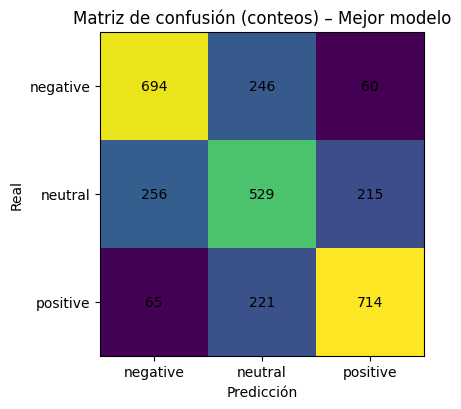

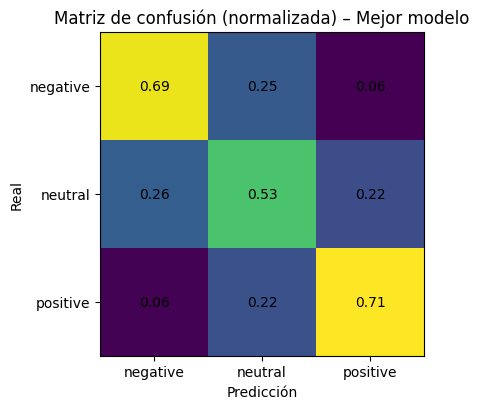

Guardadas matrices en: /content/drive/MyDrive/Proyecto_Grupo4/Results


In [59]:
preds_path = CSV_PREDS
if os.path.exists(preds_path):
    dfp = pd.read_csv(preds_path)
    y_true, y_pred = dfp["y_true"].values, dfp["y_pred"].values

    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2]).astype(np.float32)

    def plot_cm(cm, title, normalize=False, fname=None):
        M = cm.copy()
        if normalize:
            M = M / M.sum(axis=1, keepdims=True).clip(min=1)
        fig, ax = plt.subplots(figsize=(5.2,4.2))
        im = ax.imshow(M)
        ax.set_title(title)
        ax.set_xticks(range(3)); ax.set_xticklabels(["negative","neutral","positive"])
        ax.set_yticks(range(3)); ax.set_yticklabels(["negative","neutral","positive"])
        for i in range(3):
            for j in range(3):
                ax.text(j, i, f"{M[i,j]:.2f}" if normalize else f"{int(cm[i,j])}",
                        ha="center", va="center")
        ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
        plt.tight_layout()
        if fname: plt.savefig(fname, dpi=300)
        plt.show()

    plot_cm(cm, "Matriz de confusión (conteos) – Mejor modelo", fname=f"{RESULTS}/03_best_cm_counts.png")
    plot_cm(cm, "Matriz de confusión (normalizada) – Mejor modelo", fname=f"{RESULTS}/03_best_cm_norm.png", normalize=True)
    print("Guardadas matrices en:", RESULTS)
else:
    print("No encontré test_predictions.csv; si quieres matrices, genera ese archivo en el Notebook 02.")


In [62]:
# Buscamos la mejor configuración de softmax en validación
soft = df_grid[df_grid["model"]=="softmax"].sort_values("val_f1", ascending=False).head(1)
if not soft.empty:
    soft_val = float(soft["val_f1"].iloc[0])
    df_delta = df_grid.copy()
    df_delta["03_delta_vs_softmax"] = df_delta["val_f1"] - soft_val
    print("Δ val_f1 vs MEJOR Softmax (positivo = mejor que baseline):")
    display(df_delta.sort_values("03_delta_vs_softmax", ascending=False).head(10))
    df_delta.to_csv(f"{RESULTS}/03_delta_vs_softmax.csv", index=False)
    print("03_delta_vs_softmax.csv guardado")
else:
    print("No se encontró baseline Softmax en df_grid.")


Δ val_f1 vs MEJOR Softmax (positivo = mejor que baseline):


,model,arch,activation,lr,epochs,batch_size,wd,train_time_s,val_acc,val_f1,03_delta_vs_softmax
0,nn,"[256, 128]",tanh,0.03,20,256,0.0001,74.3,0.593000,0.592976,0.014153
1,softmax,linear,softmax,0.20,8,512,0.0001,4.3,0.577667,0.578823,0.000000
2,softmax,linear,softmax,0.30,8,512,0.0001,5.7,0.576333,0.575327,-0.003496
3,nn,"[512, 256, 128]",relu,0.02,20,256,0.0001,304.1,0.514333,0.505003,-0.073820
4,softmax,linear,softmax,0.10,8,512,0.0001,10.4,0.486667,0.476704,-0.102119
5,nn,"[256, 128]",relu,0.02,20,256,0.0001,156.2,0.488333,0.474506,-0.104317


03_delta_vs_softmax.csv guardado


Conclusiones
* Comparación de Modelos (Validación): El modelo Softmax obtuvo un promedio F1 macro ligeramente superior al de la red neuronal (0.5436 vs. 0.5241), aunque la diferencia es pequeña. Sin embargo, el tiempo de entrenamiento de Softmax fue significativamente menor (4.8s) comparado con la red neuronal (179.7s).

* Mejor Configuración en NN: Dentro de las redes neuronales, la arquitectura [256, 128] con activación tanh alcanzó el mejor val_f1 (0.5929), superando a otras combinaciones como [512, 256, 128] con relu.

* Top 3 Modelos (Test): El mejor modelo en test fue la NN [256, 128] con tanh, con un test_f1 de 0.6485 y test_acc de 0.6493. Le siguieron dos modelos Softmax (softmax/linear) con test_f1 de 0.6060 y 0.6014 respectivamente. Esto indica que, aunque Softmax fue competitivo en validación, la NN generalizó mejor en test.

* Matriz de Confusión del Mejor Modelo: Clases “positive” y “negative” presentan un buen desempeño (recall ~0.71 y 0.69 respectivamente).La clase “neutral” sigue siendo la más difícil de clasificar (recall ~0.53), mostrando confusión principalmente con negative.

* Balance Rendimiento–Costo Computacional: Si el objetivo es máxima precisión, la NN [256, 128] con tanh es la mejor opción.Si el objetivo es eficiencia en tiempo, Softmax es competitivo con mucho menor costo de entrenamiento.